In [83]:
#by Willkie
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from datetime import datetime

warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
#https://discord.com/channels/1134059900666916935/1283610000484208670

In [ ]:
# Open the file in read mode
file_path = "1212.txt"  # Replace with the path to your text file
with open(file_path, "r", encoding="utf-8") as file:
    # Read all lines
    lines = file.readlines()
# Display the content
for line in lines:
    print(line.strip())  # .strip() removes leading/trailing whitespace or newline characters

In [282]:
import re
import pandas as pd
from datetime import datetime

# Job dictionary and spec ranges
job_dict = {
    "허": "허밋", "시": "시프", "썬": "썬콜", "불독": "불독",
    "프": "프리스트", "레": "레인저", "저": "저격수",
    "용": "용기사", "크": "크루세이더", "나": "나이트"
}
job_spec_ranges = {
    "용": (3000, 7000), "크": (2000, 7000), "나": (2000, 6000),
    "허": (1500, 3500), "시": (1500, 4000), "썬": (500, 1000),
    "불독": (500, 1000), "프": (500, 1000), "레": (2000, 5000),
    "저": (2000, 5000)
}
level_min, level_max = 80, 200

# Regex patterns
time_pattern = r"(오전|오후) \d{1,2}:\d{2}"
job_pattern = r"(\d{2,3})\s?(" + "|".join(job_dict.keys()) + r")"
spec_pattern = r"(\d{3,4})"
map_pattern = r"(망용둥|위용둥|와협|블와둥|협동|레와둥|붉켄|검켄|푸켄|불어전|물어전|오징어|망둥어|듀파|갈림길|골짜기)"

def extract_level_and_spec(text, job_match_end, level_range, spec_range):
    numbers = [(int(x), match.start()) for match in re.finditer(r"\b\d{2,4}\b", text) for x in [match.group()]]
    level, spec = None, None
    for num, position in numbers:
        if level is None and level_range[0] <= num <= level_range[1]:
            level = num
        elif spec is None and spec_range[0] <= num <= spec_range[1]:
            spec = num
    if level and spec and level == spec:
        spec = None
    return level, spec

def collect_initial_data(file_path):
    columns = ["party_id", "time", "level", "job", "spec", "map", "date", "valid", "valid_spec"]
    df = pd.DataFrame(columns=columns)

    # Format date as "2024-12-09"
    month = file_path[-8:-6]
    day = file_path[-6:-4]
    date_from_file = f"2024-{month}-{day}"
    
    party_id = 0
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.read()

    blocks = data.split("오늘")
    for block in blocks[1:]:
        time_match = re.search(time_pattern, block)
        time = time_match.group(0) if time_match else None
        map_match = re.search(map_pattern, block)
        map_name = map_match.group(0) if map_match else None
        job_matches = re.finditer(job_pattern, block)
        for job_match in job_matches:
            job_short = job_match.group(2)
            job_full = job_dict.get(job_short, "Unknown")
            spec_search_area = block[job_match.end():]
            level, spec = extract_level_and_spec(spec_search_area, job_match.end(), (level_min, level_max), job_spec_ranges.get(job_short, (None, None)))
            valid = spec is not None and level is not None
            
            # Default valid_spec as None initially
            valid_spec = None
            
            # Append new row to DataFrame
            df = pd.concat([
                df,
                pd.DataFrame([{
                    "party_id": party_id,
                    "time": time,
                    "level": level,
                    "job": job_full,
                    "spec": spec,
                    "map": map_name,
                    "date": date_from_file,
                    "valid": valid,
                    "valid_spec": valid_spec
                }])
            ], ignore_index=True)
        party_id += 1
    
    # Calculate average spec_to_level by job
    df["spec_to_level"] = df.apply(
        lambda row: row["spec"] / row["level"] if pd.notna(row["spec"]) and pd.notna(row["level"]) else None,
        axis=1
    )
    average_ratios = df.groupby("job")["spec_to_level"].mean().reset_index()
    average_ratios.rename(columns={"spec_to_level": "average_spec_to_level"}, inplace=True)
    df = df.merge(average_ratios, on="job", how="left")
    
    # Calculate valid_spec based on 20% margin
    def is_valid_spec(row):
        if pd.notna(row["spec_to_level"]) and pd.notna(row["average_spec_to_level"]):
            lower_bound = 0.8 * row["average_spec_to_level"]
            upper_bound = 1.2 * row["average_spec_to_level"]
            return lower_bound <= row["spec_to_level"] <= upper_bound
        return False
    
    df["valid_spec"] = df.apply(is_valid_spec, axis=1)
    # Drop intermediate columns if needed
    df.drop(columns=["spec_to_level", "average_spec_to_level"], inplace=True)
    
    output_file = file_path.replace('.txt', '.csv')
    print(f"Data saved as {output_file}")
    df.to_csv(output_file, index=False)
    return df

def reprocess_data(df, file_path):
    """
    Reprocess data without recalculating valid_spec.
    """
    # Copy the original DataFrame
    processed_df = df.copy()

    # Update valid column based on valid_spec and other conditions
    processed_df["valid"] = processed_df.apply(
        lambda row: pd.notna(row["map"]) and pd.notna(row["job"]) and row["valid_spec"],
        axis=1
    )
    # Save the processed DataFrame to a CSV file
    refined_output_file = file_path.replace('.txt', '_processed.csv')
    processed_df.to_csv(refined_output_file, index=False)

    print(f"Processed data saved as {refined_output_file}")
    return processed_df

def process_files(file_paths):
    """
    Processes multiple text files, combines them into single DataFrames for raw and processed data,
    and saves the final outputs as CSV files.
    """
    all_raw_data = []
    all_processed_data = []

    for file_path in file_paths:
        # Process each file and collect raw and processed data
        df = collect_initial_data(file_path)
        processed_df = reprocess_data(df, file_path)
        
        all_raw_data.append(df)
        all_processed_data.append(processed_df)

    # Combine all DataFrames
    combined_raw_data = pd.concat(all_raw_data, ignore_index=True)
    combined_processed_data = pd.concat(all_processed_data, ignore_index=True)

    # Save the combined DataFrames
    combined_raw_data.to_csv("combined_raw_data.csv", index=False)
    combined_processed_data.to_csv("combined_processed_data.csv", index=False)

    print("All dates combined and saved as 'combined_raw_data.csv' and 'combined_processed_data.csv'.")

    return combined_raw_data, combined_processed_data


# List of file paths
file_paths = ["1207.txt", "1208.txt", "1209.txt", "1210.txt", "1211.txt", "1212.txt", "1213.txt"]

# Process files and combine data
df_combined_raw, df_combined_processed = process_files(file_paths)

Data saved as 1207.csv
Processed data saved as 1207_processed.csv
Data saved as 1208.csv
Processed data saved as 1208_processed.csv
Data saved as 1209.csv
Processed data saved as 1209_processed.csv
Data saved as 1210.csv
Processed data saved as 1210_processed.csv
Data saved as 1211.csv
Processed data saved as 1211_processed.csv
Data saved as 1212.csv
Processed data saved as 1212_processed.csv
Data saved as 1213.csv
Processed data saved as 1213_processed.csv
All dates combined and saved as 'combined_raw_data.csv' and 'combined_processed_data.csv'.


In [283]:
df = pd.read_csv("combined_raw_data.csv")
df

,party_id,time,level,job,spec,map,date,valid,valid_spec
0,0,오후 3:40,NaN,썬콜,NaN,불어전,2024-12-07,False,False
1,0,오후 3:40,NaN,프리스트,NaN,불어전,2024-12-07,False,False
2,0,오후 3:40,NaN,썬콜,NaN,불어전,2024-12-07,False,False
3,0,오후 3:40,NaN,프리스트,NaN,불어전,2024-12-07,False,False
4,0,오후 3:40,NaN,프리스트,NaN,불어전,2024-12-07,False,False
...,...,...,...,...,...,...,...,...,...
6151,214,오후 5:47,NaN,썬콜,NaN,협동,2024-12-13,False,False
6152,215,오후 5:47,170.0,크루세이더,NaN,망둥어,2024-12-13,False,False
6153,215,오후 5:47,200.0,저격수,NaN,망둥어,2024-12-13,False,False
6154,215,오후 5:47,200.0,용기사,NaN,망둥어,2024-12-13,False,False


In [284]:
df_processed = pd.read_csv("combined_processed_data.csv")
df_processed

,party_id,time,level,job,spec,map,date,valid,valid_spec
0,0,오후 3:40,NaN,썬콜,NaN,불어전,2024-12-07,False,False
1,0,오후 3:40,NaN,프리스트,NaN,불어전,2024-12-07,False,False
2,0,오후 3:40,NaN,썬콜,NaN,불어전,2024-12-07,False,False
3,0,오후 3:40,NaN,프리스트,NaN,불어전,2024-12-07,False,False
4,0,오후 3:40,NaN,프리스트,NaN,불어전,2024-12-07,False,False
...,...,...,...,...,...,...,...,...,...
6151,214,오후 5:47,NaN,썬콜,NaN,협동,2024-12-13,False,False
6152,215,오후 5:47,170.0,크루세이더,NaN,망둥어,2024-12-13,False,False
6153,215,오후 5:47,200.0,저격수,NaN,망둥어,2024-12-13,False,False
6154,215,오후 5:47,200.0,용기사,NaN,망둥어,2024-12-13,False,False


In [285]:
hermit = df[(df['job'] == '허밋')]
hermit
hermit_valid = hermit[hermit['valid_spec'] == True]
hermit_valid

,party_id,time,level,job,spec,map,date,valid,valid_spec
16,6,오후 3:31,127.0,허밋,2096.0,오징어,2024-12-07,True,True
17,6,오후 3:31,109.0,허밋,2300.0,오징어,2024-12-07,True,True
361,149,오후 3:41,127.0,허밋,2096.0,오징어,2024-12-07,True,True
362,149,오후 3:41,109.0,허밋,2300.0,오징어,2024-12-07,True,True
365,150,오후 3:41,104.0,허밋,1870.0,NaN,2024-12-07,True,True
...,...,...,...,...,...,...,...,...,...
6014,168,오후 5:45,138.0,허밋,2514.0,망용둥,2024-12-13,True,True
6015,168,오후 5:45,138.0,허밋,2514.0,망용둥,2024-12-13,True,True
6016,168,오후 5:45,138.0,허밋,2514.0,망용둥,2024-12-13,True,True
6017,168,오후 5:45,138.0,허밋,2514.0,망용둥,2024-12-13,True,True


In [286]:
unique_maps = df["map"].unique()
print("Maps in the data:")
for map_name in unique_maps:
    print(map_name)

Maps in the data:
불어전
붉켄
nan
오징어
듀파
물어전
망용둥
망둥어
위용둥
레와둥
골짜기
푸켄
검켄
협동
와협
갈림길
블와둥


In [287]:
# Display basic information about the DataFrame
print("Basic Info:")
print(df.info())

print("\nData Overview:")
print(df.head())

# Count frequency of maps
map_counts = df["map"].value_counts()

print("\nMap Frequency:")
print(map_counts)

# Count frequency of jobs
job_counts = df["job"].value_counts()

print("\nJob Frequency:")
print(job_counts)

# Distribution of levels by job
print("\nLevel Statistics by Job:")
print(df.groupby("job")["level"].describe())

# Convert 'level' column to numeric for analysis
df["level"] = pd.to_numeric(df["level"], errors="coerce")

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6156 entries, 0 to 6155
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   party_id    6156 non-null   int64  
 1   time        6156 non-null   object 
 2   level       2583 non-null   float64
 3   job         6156 non-null   object 
 4   spec        1006 non-null   float64
 5   map         5042 non-null   object 
 6   date        6156 non-null   object 
 7   valid       6156 non-null   bool   
 8   valid_spec  6156 non-null   bool   
dtypes: bool(2), float64(2), int64(1), object(4)
memory usage: 348.8+ KB
None

Data Overview:
   party_id     time  level   job  spec  map        date  valid  valid_spec
0         0  오후 3:40    NaN    썬콜   NaN  불어전  2024-12-07  False       False
1         0  오후 3:40    NaN  프리스트   NaN  불어전  2024-12-07  False       False
2         0  오후 3:40    NaN    썬콜   NaN  불어전  2024-12-07  False       False
3         0  오후 3:40    NaN  프리스트

In [288]:
# 1. Map Distribution
def map_dist(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(y="map", data=df, order=map_counts.index, palette="viridis")
    plt.title("Frequency of Maps")
    plt.xlabel("Count")
    plt.ylabel("Map")
    plt.tight_layout()
    plt.show()

# 2. Job Distribution
def job_dist(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(y="job", data=df, order=job_counts.index, palette="coolwarm")
    plt.title("Frequency of Jobs")
    plt.xlabel("Count")
    plt.ylabel("Job")
    plt.tight_layout()
    plt.show()

# 3. Level Distribution Overall
def level_dist(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df["level"], kde=True, bins=30, color="skyblue")
    plt.title("Level Distribution")
    plt.xlabel("Level")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 4. Level Distribution by Job
def level_dist_by_job(df):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=df["job"], y=df["level"], data=df, palette="muted")
    plt.title("Level Distribution by Job")
    plt.xlabel("Job")
    plt.ylabel("Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [289]:
def average_spec_by_job(df):
    # Ensure the 'spec' column is numeric, replacing non-numeric values with NaN
    df['spec'] = pd.to_numeric(df['spec'], errors='coerce')
    
    # Calculate the average spec by job, ignoring NaN values
    average_spec_by_job = df.groupby('job')['spec'].mean().reset_index()
    
    # Fill NaN values with 0 for jobs with no spec data
    average_spec_by_job['spec'] = average_spec_by_job['spec'].fillna(0)
    
    # Ensure all jobs are represented, even if they have no spec data
    all_jobs = list(job_dict.values())  # Ensure all jobs from job_dict are present
    missing_jobs = [job for job in all_jobs if job not in average_spec_by_job['job'].values]
    
    # Create a DataFrame for missing jobs with spec value set to 0
    missing_jobs_df = pd.DataFrame({'job': missing_jobs, 'spec': [0]*len(missing_jobs)})
    
    # Concatenate the missing jobs DataFrame with the existing DataFrame
    average_spec_by_job = pd.concat([average_spec_by_job, missing_jobs_df], ignore_index=True)
    
    # Sort the data for better visualization
    average_spec_by_job = average_spec_by_job.sort_values('spec', ascending=False)
    
    # Set up the visualizations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='spec', y='job', data=average_spec_by_job, palette='viridis')
    
    # Add labels and title
    plt.xlabel('Average Spec')
    plt.ylabel('Job')
    plt.title('Average Spec by Job')
    
    # Display the plot
    plt.show()

In [290]:
def plot_job_frequency_by_map(df):
    # Count the number of occurrences of each job in each map
    job_map_counts = df.groupby(["map", "job"]).size().reset_index(name="count")
    
    # Create a pivot table for better visualization
    job_map_pivot = job_map_counts.pivot(index="map", columns="job", values="count").fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(job_map_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Job Count'})
    plt.title("Job Frequency by Map")
    plt.ylabel("Map")
    plt.xlabel("Job")
    plt.show()

In [291]:
def plot_level_spec_by_job(df, job):
    hermit_df = df[df["job"] == job]
    
    # Plot Level vs Spec for Hermit without including map
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=hermit_df, x="level", y="spec", s=100)
    plt.title("Hermit's Level vs Spec")
    plt.xlabel("Level")
    plt.ylabel("Spec")
    plt.show()

In [292]:
def plot_level_by_map_by_job(df, job):
    hermit_df = df[df["job"] == job]
    
    # Plot Level by Map for Hermit
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=hermit_df, x="map", y="level", palette="Set2")
    plt.title("Hermit's Level by Map")
    plt.xlabel("Map")
    plt.ylabel("Level")
    plt.xticks(rotation=45)
    plt.show()

In [293]:
def plot_spec_to_level_ratio_by_job(df):
    # Compute the spec-to-level ratio
    df["spec_to_level"] = df.apply(
        lambda row: row["spec"] / row["level"] if pd.notna(row["spec"]) and pd.notna(row["level"]) else None,
        axis=1
    )
    
    # Plot spec-to-level ratio by job
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="job", y="spec_to_level", palette="Set3")
    plt.title("Spec-to-Level Ratio by Job")
    plt.xlabel("Job")
    plt.ylabel("Spec-to-Level Ratio")
    plt.xticks(rotation=45)
    plt.show()


In [294]:
def plot_level_distribution_by_job(df):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=df, x=df["level"], hue=df["job"], multiple="stack", bins=20, palette="Set2")
    plt.title("Distribution of Levels by Job")
    plt.xlabel("Level")
    plt.ylabel("Frequency")
    plt.show()

In [295]:
import matplotlib.pyplot as plt

def visualize_spec_validity_by_map(df):
    """
    Visualizes the validity of the data by map using stacked bars.
    """
    # Count valid and invalid entries for each map
    spec_validity_by_map = df.groupby(['map', 'valid_spec']).size().unstack(fill_value=0)

    # Reset index for plotting
    spec_validity_by_map = spec_validity_by_map.reset_index()

    # Set up figure
    plt.figure(figsize=(12, 7))

    # Plot stacked bars
    plt.bar(spec_validity_by_map['map'], spec_validity_by_map[0], label='미기재', color='#FF6F61')
    plt.bar(spec_validity_by_map['map'], spec_validity_by_map[1], bottom=spec_validity_by_map[0], label='기재', color='#6B8E23')

    # Customize plot
    plt.title('맵별 스공기재여부', fontsize=16)
    plt.xlabel('Map', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Spec Validity', fontsize=12)
    plt.tight_layout()
    plt.show()


def visualize_spec_validity_by_job(df):
    """
    Visualizes the validity of the data by job using stacked bars.
    """
    # Count valid and invalid entries for each job
    validity_by_job = df.groupby(['job', 'valid_spec']).size().unstack(fill_value=0)

    # Reset index for plotting
    validity_by_job = validity_by_job.reset_index()

    # Set up figure
    plt.figure(figsize=(12, 7))

    # Plot stacked bars
    plt.bar(validity_by_job['job'], validity_by_job[0], label='미기재', color='#FF6F61')
    plt.bar(validity_by_job['job'], validity_by_job[1], bottom=validity_by_job[0], label='기재', color='#6B8E23')

    # Customize plot
    plt.title('직업별 스공기재여부', fontsize=16)
    plt.xlabel('Job', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='스공기재여부', fontsize=12)
    plt.tight_layout()
    plt.show()

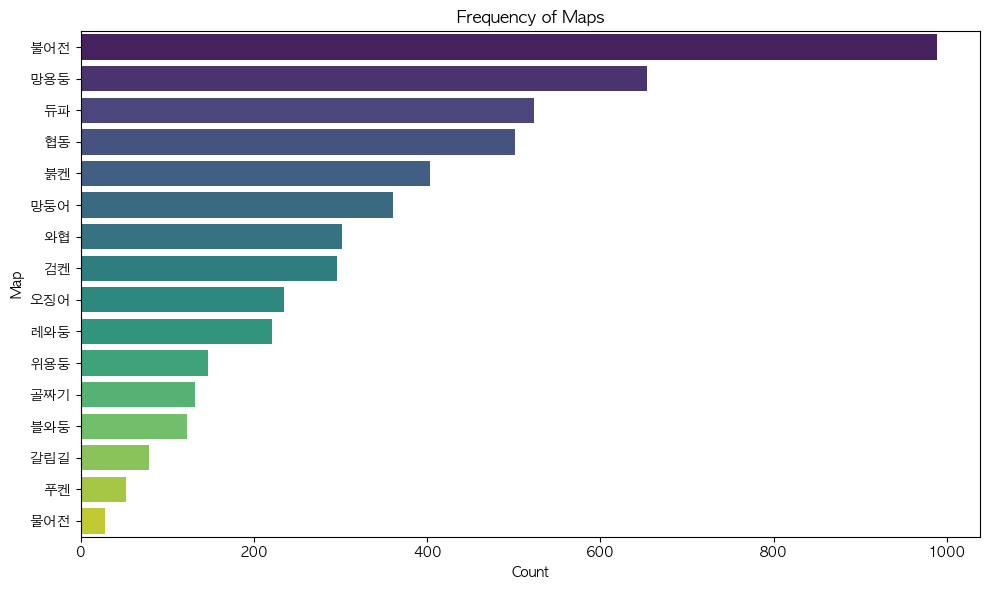

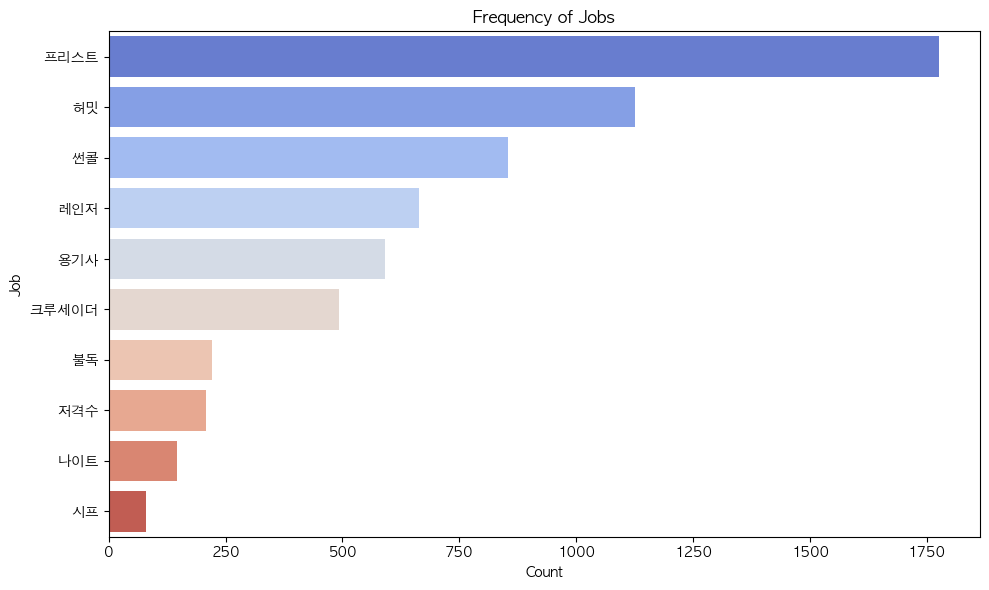

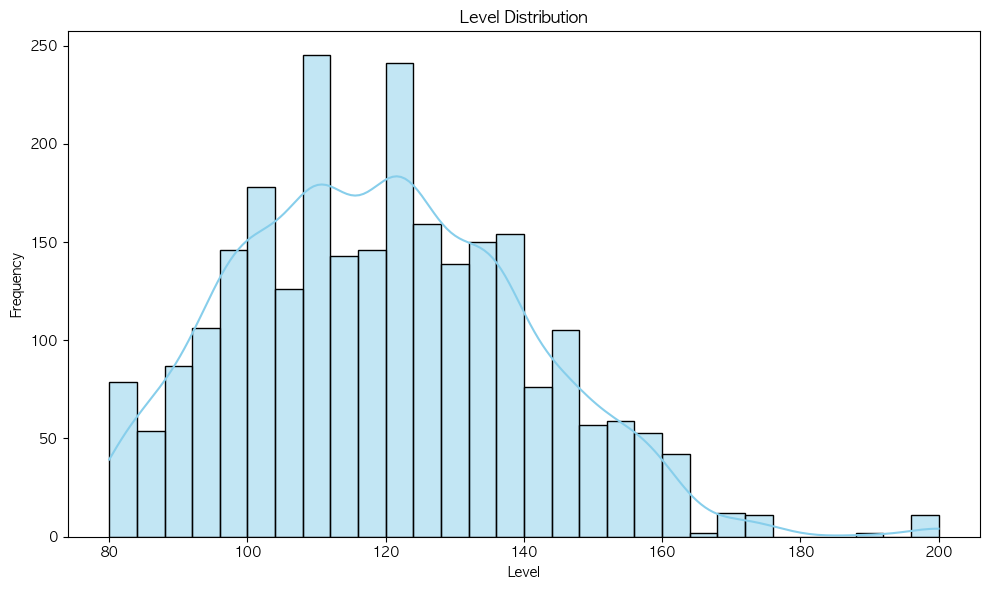

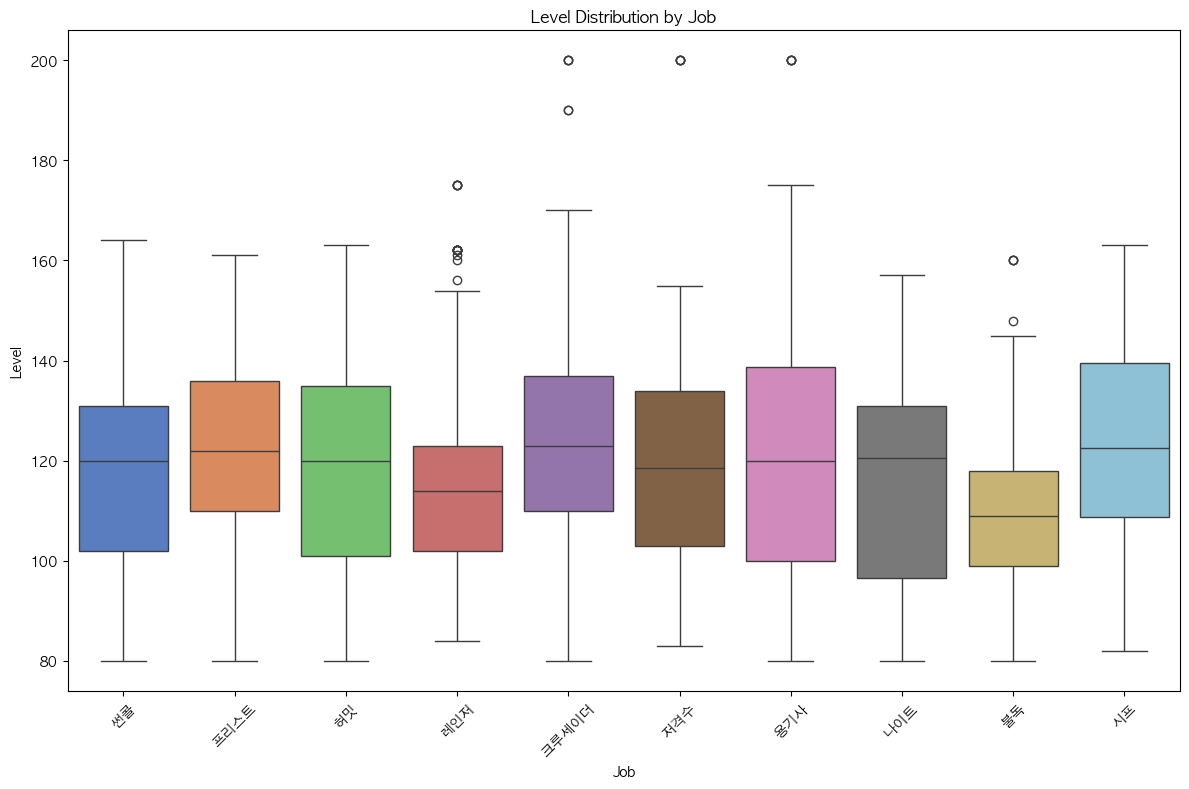

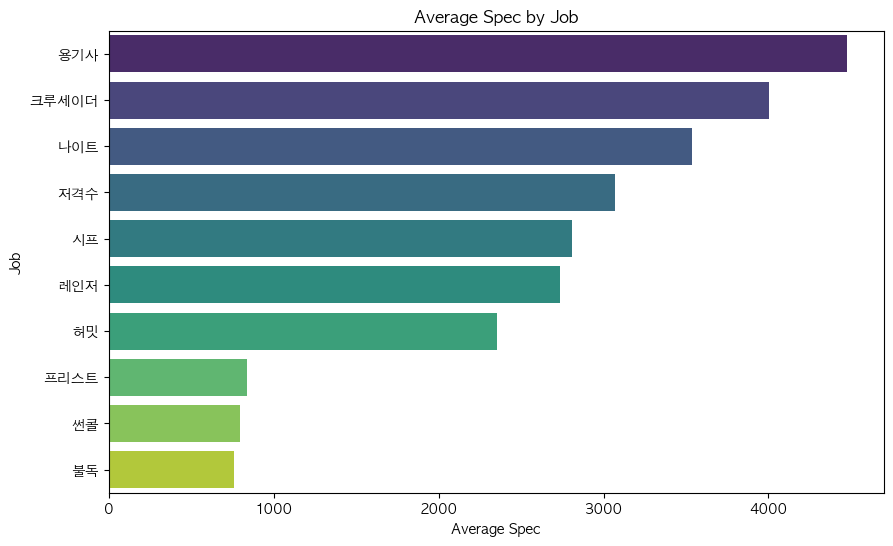

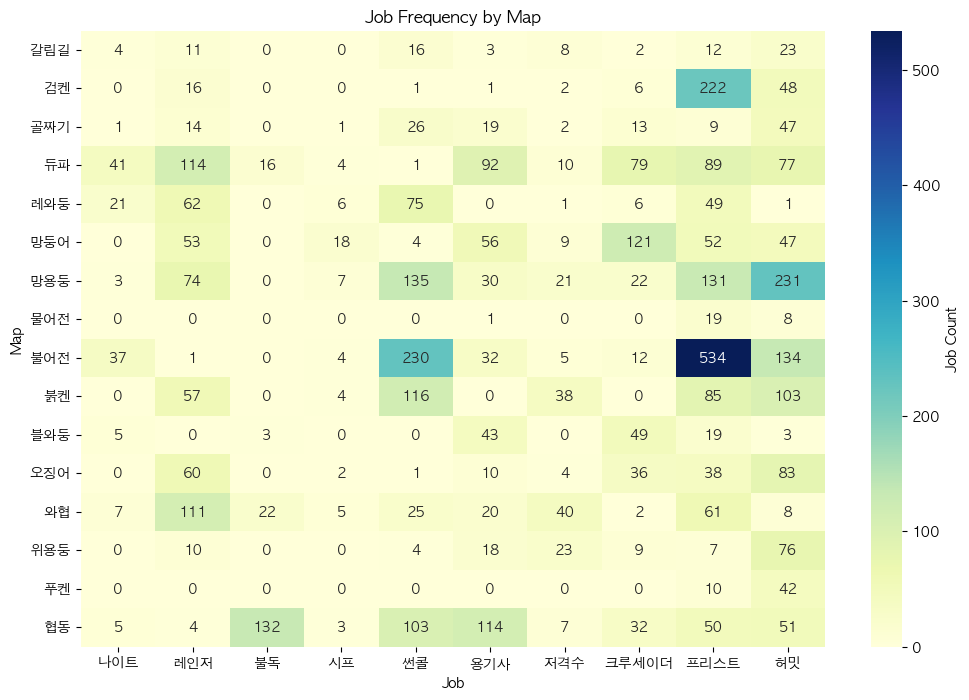

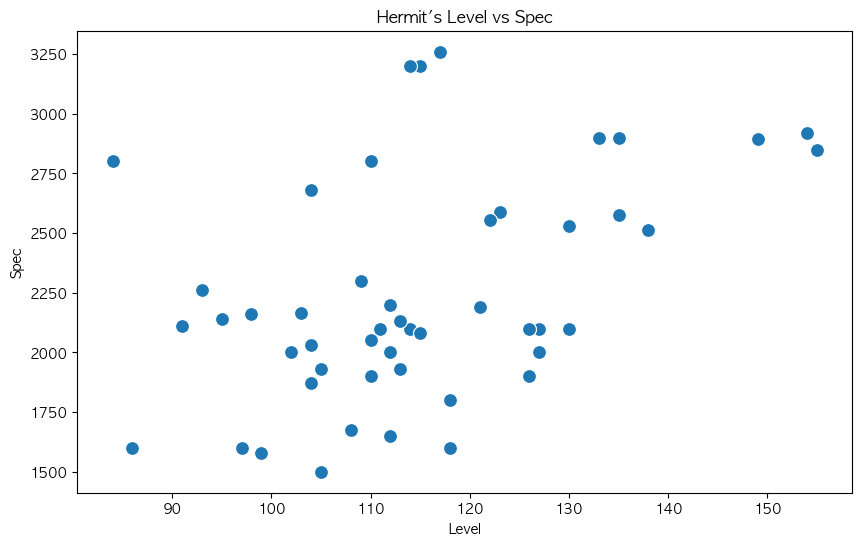

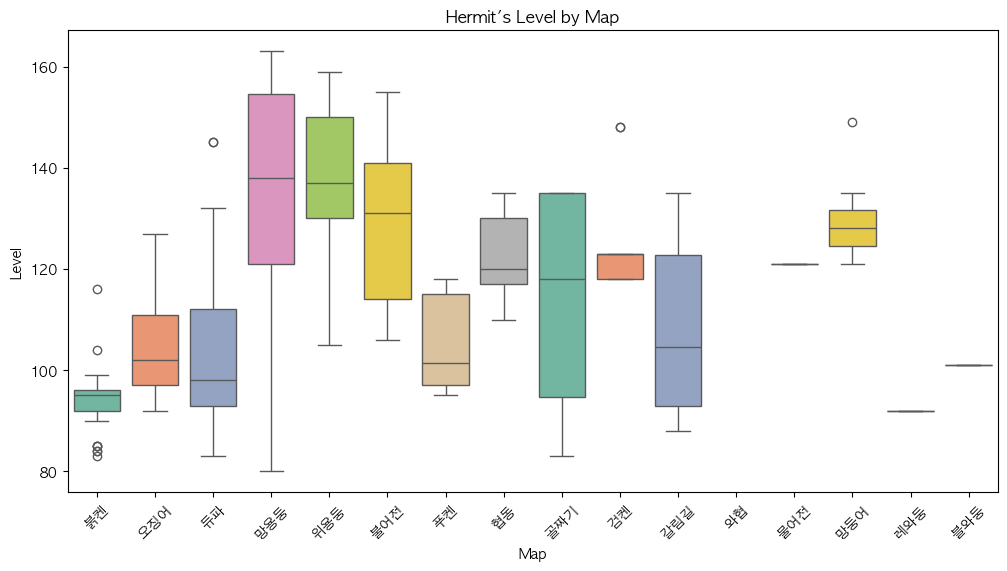

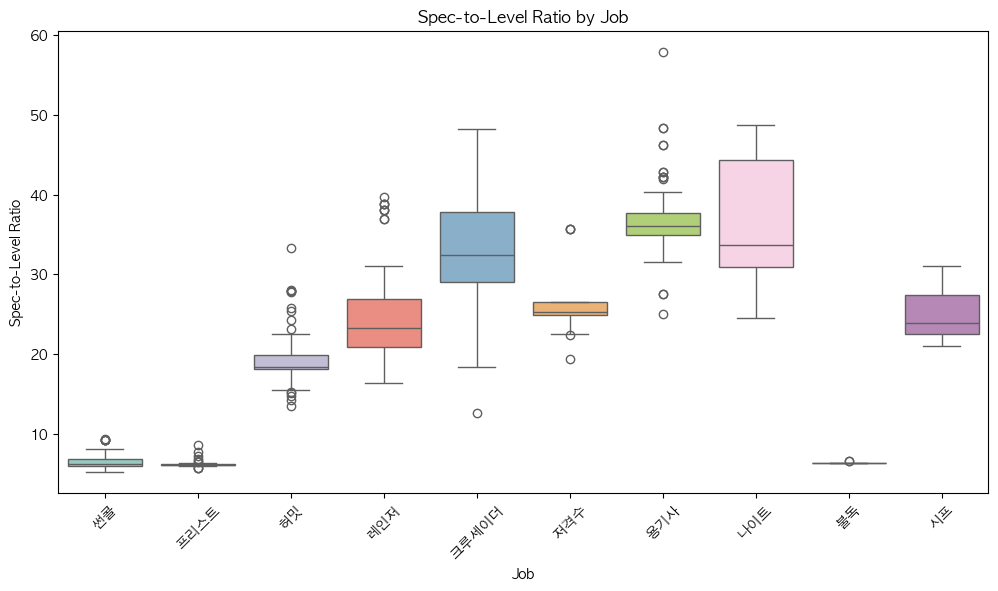

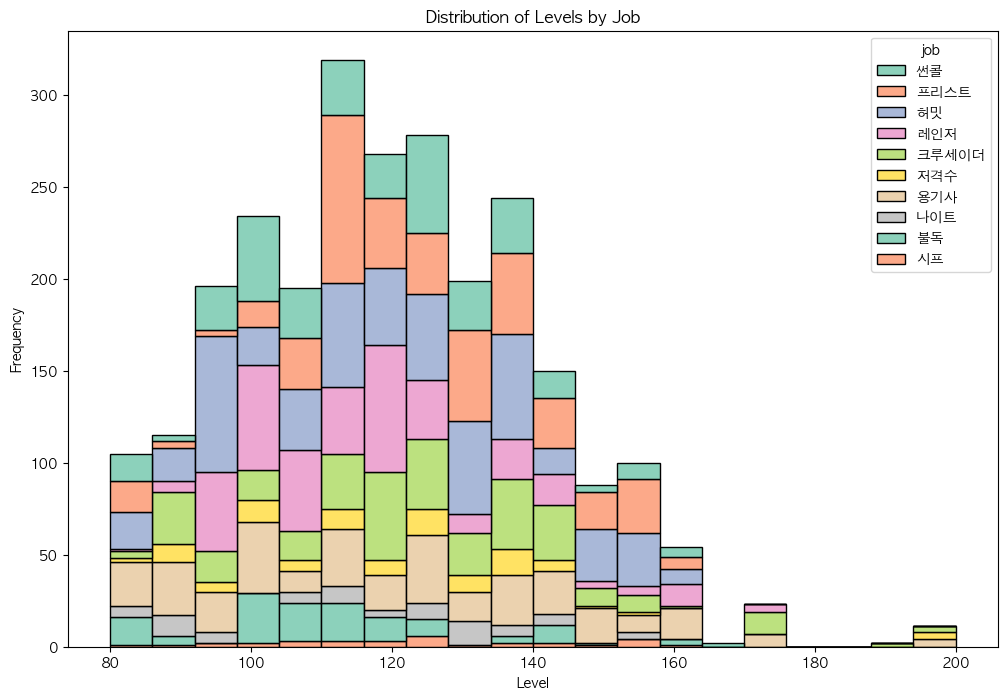

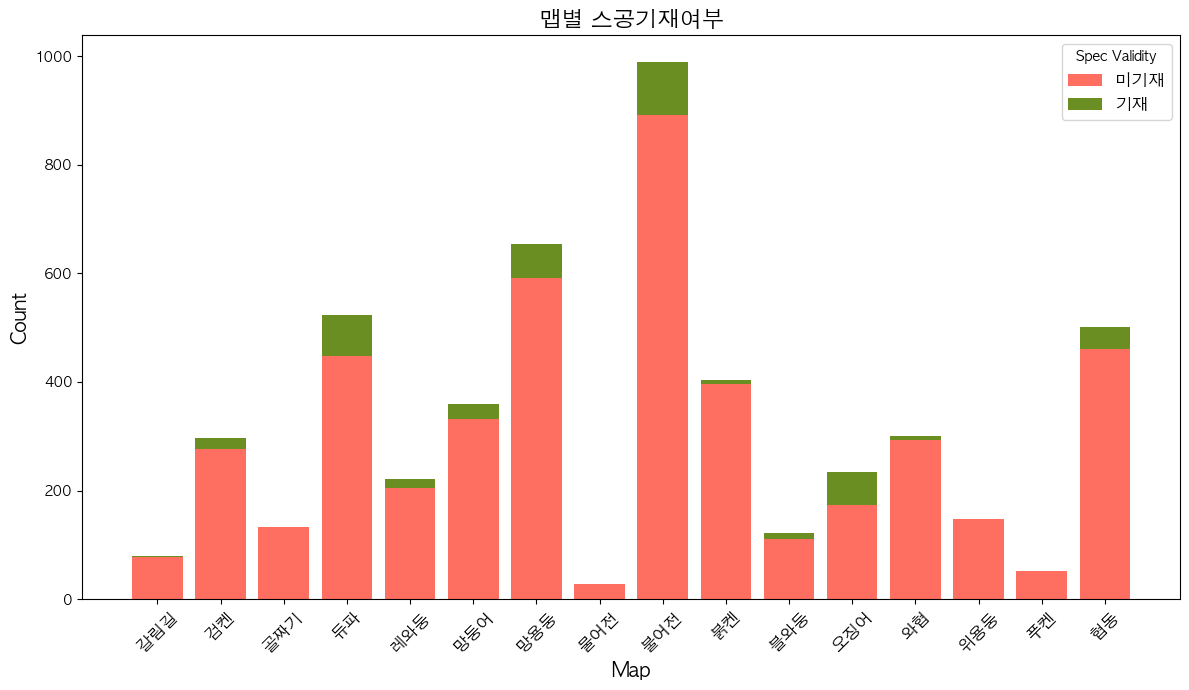

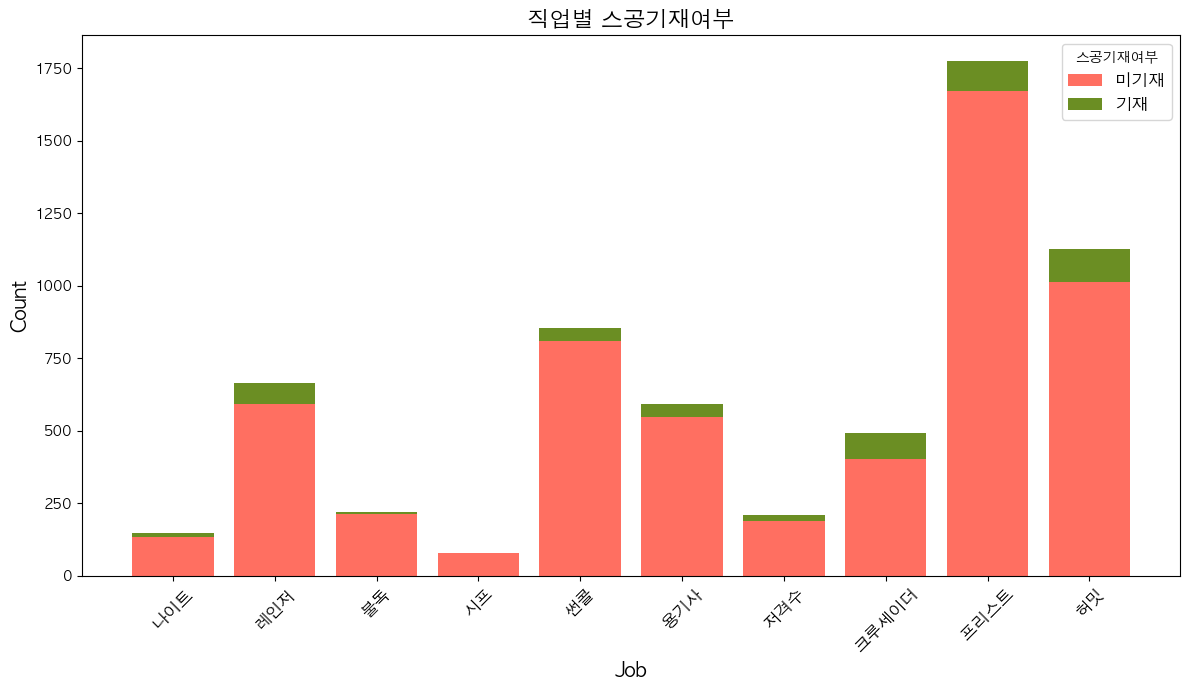

In [296]:
map_dist(df)
job_dist(df)
level_dist(df)
level_dist_by_job(df)

average_spec_by_job(df)

plot_job_frequency_by_map(df)
plot_level_spec_by_job(df_processed, "허밋")
plot_level_by_map_by_job(df, "허밋")
plot_spec_to_level_ratio_by_job(df_processed)
plot_level_distribution_by_job(df)
visualize_spec_validity_by_map(df)
visualize_spec_validity_by_job(df)

In [281]:
#by Willkie